# Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в
столбце '*num_orders*'.

# Содержание
1. [__Подготовка__](#preparation)
    * [__Вывод__](#findings_1)
2. [__Анализ__](#analysis)
    * [__Разложение данных__](#data_decompose)
    * [__Подготовка признаков__](#features_preparation)
    * [__Вывод__](#findings_2)
3. [__Обучение__](#learning_models)
    * [__DummyModel__](#dummymodel)
    * [__LinearRegression__](#linearregression)
    * [__LGBMRegressor__](#lgbmregressor)
    * [__RandomForestRegressor__](#randomforestregressor)
    * [__Вывод__](#findings_3)
4. [__Тестирование__](#testing_model)
    * [__Вывод__](#findings_4)
    
5. [__Выводы__](#findings)

# 1. Подготовка <a name='preparation'></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import mean_squared_error as mse, make_scorer
from pandas.plotting import register_matplotlib_converters
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb


register_matplotlib_converters()
%matplotlib inline

In [3]:
taxi_data = pd.read_csv('/data/taxi.csv', parse_dates=[0], index_col=0)

In [4]:
taxi_data.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [5]:
taxi_data.sort_index(inplace=True)

In [6]:
taxi_data = taxi_data.resample('1H').sum()

In [7]:
taxi_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
num_orders    4416 non-null int64
dtypes: int64(1)
memory usage: 69.0 KB


In [8]:
taxi_data.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


## Вывод: <a name='findings_1'></a>

Данные преобразованы по часу и проверены на отсутствие пропусков и аномальных значений. Итоговое количество объектов 4416.

# 2. Анализ <a name='analysis'></a>

## Разложение данных <a name='data_decompose'></a>

Выделим тренды и сезонности в данных

In [9]:
decompose = seasonal_decompose(taxi_data)

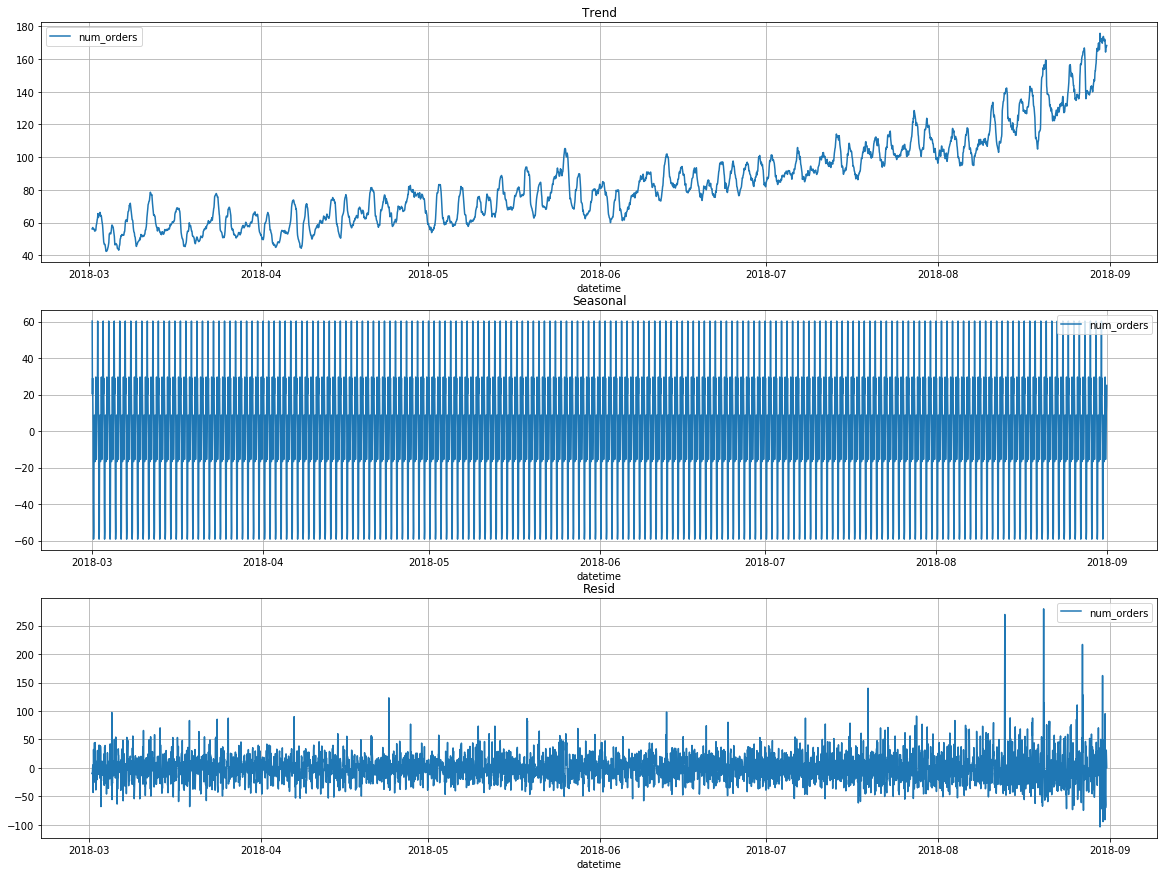

In [10]:
f, ax = plt.subplots(nrows=3, figsize=(20, 15));
sns.lineplot(data=decompose.trend, ax=ax[0]);
ax[0].grid()
ax[0].set_title('Trend')
sns.lineplot(data=decompose.seasonal, ax=ax[1]);
ax[1].grid()
ax[1].set_title('Seasonal')
sns.lineplot(data=decompose.resid, ax=ax[2]);
ax[2].grid()
ax[2].set_title('Resid')
f.show()

Растущий тренд и дневная сезонность. Причет тренд растет не линейно, скорее рост больше похож на экспоненциальный. При таком росте чтобы добиться желаемого результата max(rmse)=48 на тестовой выборке в 10% важно не разделять данные на валидационную выборку. И чем больше будет тестовая выборка тем хуже она будет предсказываться

С остатками мы ничего делать не будем, просто посмотрим на их распределение

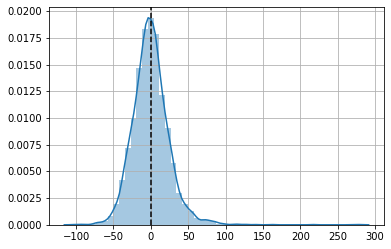

In [11]:
ax = sns.distplot(decompose.resid.dropna())
plt.axvline(0, color="k", linestyle="--");
ax.grid()

In [12]:
decompose.resid.std()

num_orders    24.696896
dtype: float64

Остатки распределены нормально со средним в 0 и стандартным отклонением 25

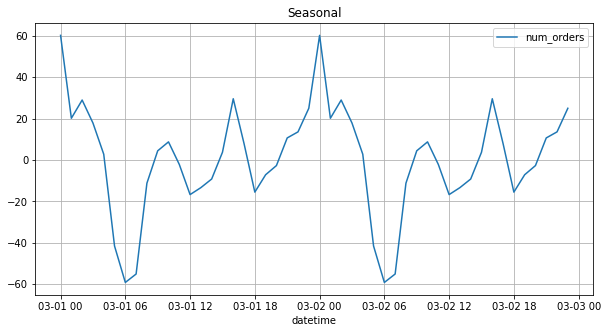

In [13]:
plt.figure(figsize=(10, 5));
ax = sns.lineplot(data=decompose.seasonal['2018-03-01':'2018-03-02'], ax=plt.gca());
ax.grid()
ax.set_title('Seasonal')
plt.show()

По графику сезонности можно увидеть, что основной пик приходится на полночь, а оновной провал - это 6 часов утра. 

## Подготовка признаков <a name='features_preparation'></a>

План:
1. Будем строить план отталкиваясь от следующих моделей:
    * NeuralNetwork
    * LGBMRegressor
    * RandomForestRegressor
2. Добавим длполнительные признаки такие как месяц, день, час, сдвиги значений и скользящую среднюю
2. Для линейной регресси важно, что бы все признаки были взвешены и не коррелированы поэтому применем StandardScaler и проверим на корреляцию.
3. Для бустинга категориальыне признаки, такие как month, day, dayofweek, hour,  менять не нужно.

Напишем функцию для добавления признаков.

In [14]:
def add_features(data: pd.DataFrame, max_lag: int, moving_average_per: int):
    """Add datetime features (month, day, dayofweek, hour), shift features, moving average feature"""
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag+1):
        data[f'lag_{lag}'] = data['num_orders'].shift(periods=lag)
        
    data['moving_average'] = data['num_orders'].shift().rolling(moving_average_per).mean()

In [15]:
max_lag = 15
moving_average_per = 15
add_features(taxi_data, max_lag, moving_average_per)

In [16]:
taxi_data.head()

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,moving_average
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


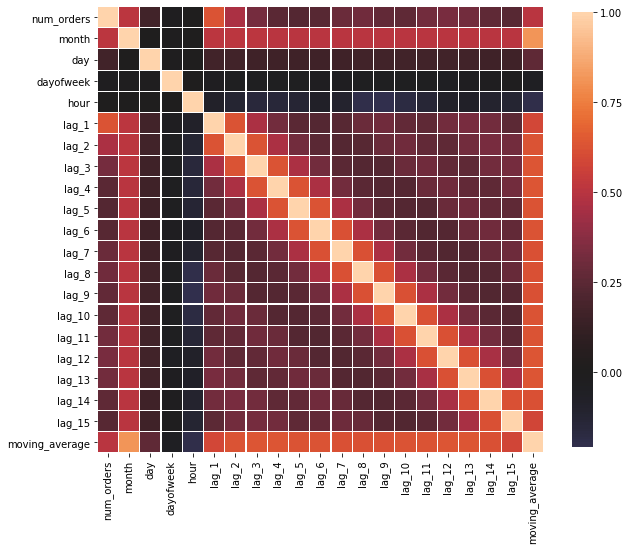

In [17]:
plt.figure(figsize=(10, 10))
sns.heatmap(taxi_data.corr(), center=0, square=True, linewidths=.1, cbar_kws={"shrink": .8}, ax=plt.gca())
plt.show()

Высокая корреляция между месяцем и скользящей средней. Обусловленно тем, что скользящее среднее растет на протяжении года. Вероятно от месяца будет лучше избавится т.к. он несет в себе меньше информации чем скользящая средняя. С целевым признаком больше всех коррелирует lag_1 т.к. он находится всего в одном шаге.

In [18]:
train_data, test_data = train_test_split(taxi_data, train_size=.9, shuffle=False)

In [19]:
train_data = train_data.dropna()

In [20]:
y_train = train_data['num_orders']
y_test = test_data['num_orders']

X_train = train_data.drop('num_orders', axis=1)
X_test = test_data.drop('num_orders', axis=1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3959, 20), (442, 20), (3959,), (442,))

In [21]:
scaler = StandardScaler()
X_train_scal = scaler.fit_transform(X_train)
X_test_scal = scaler.transform(X_test)

## Вывод: <a name='findings_2'></a>
1. После разложения данных на тренды и сезонности выявлен нелинейный тренд вверх на протяжении всего временного отрезка. Так же  обнаружена дневная сезонность с 6 утра до 12 вечера наблюдается рост заявок, после 12 идет на спад. Анализ отстатков от разложения данных показал, что остатки распределены нормально со средним равным 0 и стандартным отклонением равным 25.
2. Добалены признаки month, day, dayofweek, hour добавлены смещенные значения целевого признака от 1 до 15, добавлена скользящая средняя с периодом 15. 
3. Данные поделены на тренировочную и тестовую выборки, признаки стандартизированы

# 3. Обучение <a name='learning_models'></a>

In [21]:
def draw_plots(train_predicts):
    f, ax = plt.subplots(ncols=2, figsize=(20, 5))
    sns.lineplot(data=y_train.iloc[0: 72].values, ax=ax[0], label='Ground truth')
    sns.lineplot(data=train_predicts[0: 72], ax=ax[0], label='Predicts')
    ax[0].grid()
    ax[0].set_title('Train start')
    ax[0].legend()
    sns.lineplot(data=y_train.iloc[-72: ].values, ax=ax[1], label='Ground truth')
    sns.lineplot(data=train_predicts[-72: ], ax=ax[1], label='Predicts')
    ax[1].grid()
    ax[1].set_title('Train end')
    ax[1].legend()
    f.show()

In [22]:
# Напишем функцию rmse
rmse = lambda *args, **kwargs: mse(*args, **kwargs)**0.5
rmse_score = make_scorer(rmse, greater_is_better=False)

Т.к. мы знаем что у нас постоянно растущий тренд для проверки адекватности возьмем признак самый скоррелированный с целевым признаком, lag_1 (предшествующее значение целевого признака)

In [23]:
# Будем сохранять результаты обучения
rmse_history = pd.DataFrame()

## DummyModel <a name='dummymodel'></a>

In [24]:
train_predicts = train_data['lag_1']
rmse_history.loc['dummy', 'train'] = rmse(y_train, train_predicts)

print('training RMSE:', rmse_history.loc['dummy', 'train'])

training RMSE: 36.1709372450752


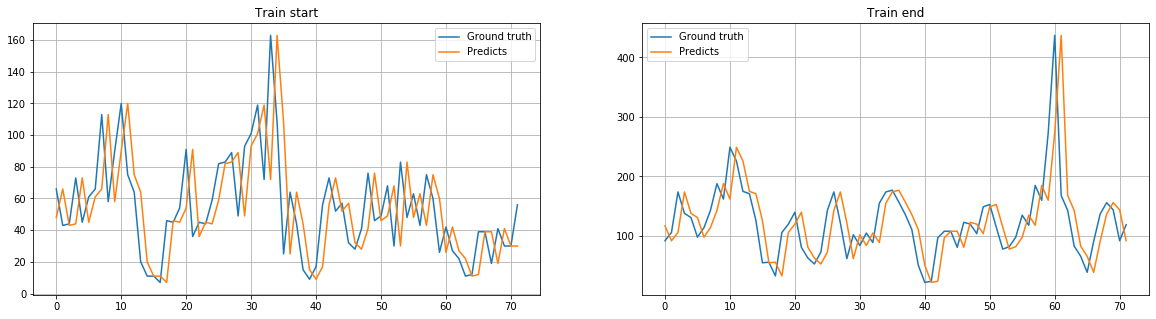

In [25]:
draw_plots(train_predicts.values)

## LinearRegression <a name='linearregression'></a>

In [26]:
linear_scores = cross_validate(LinearRegression(), X_train_scal,  y_train, scoring=rmse_score, return_train_score=True, cv=3)
linear_scores

{'fit_time': array([0.00419211, 0.04831791, 0.00459146]),
 'score_time': array([0.00116968, 0.00101233, 0.00107646]),
 'test_score': array([-27.5546796 , -28.87796444, -35.65397034]),
 'train_score': array([-31.46002055, -30.41301345, -26.97635224])}

In [27]:
linear_model = LinearRegression()
linear_model.fit(X_train_scal, y_train)
train_predicts = linear_model.predict(X_train_scal)

rmse_history.loc['linear_regression', 'train'] = rmse(y_train, train_predicts)
print('training RMSE:', rmse_history.loc['linear_regression', 'train'])

training RMSE: 29.830561711091736


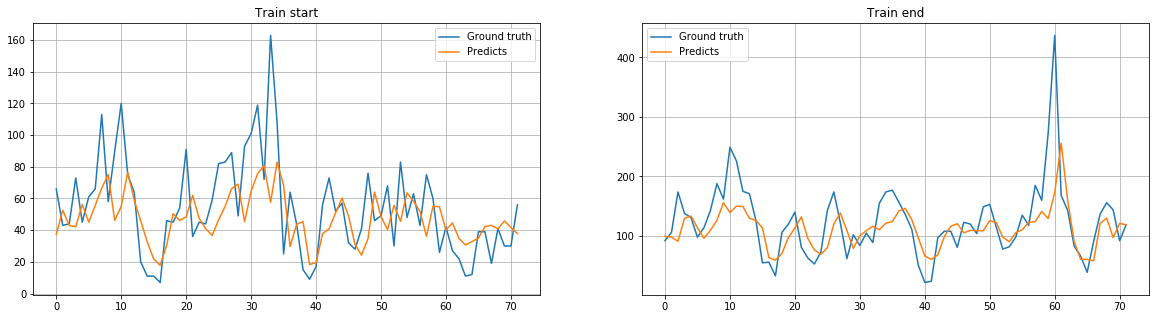

In [28]:
draw_plots(train_predicts)

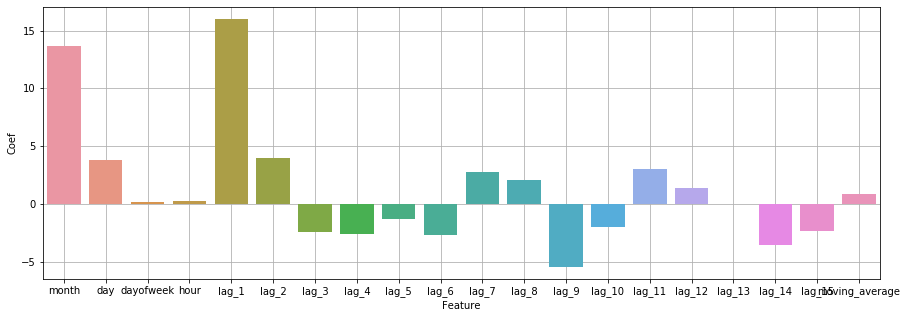

In [48]:
coef = pd.DataFrame(zip(linear_model.coef_, X_train.columns))
plt.figure(figsize=(15, 5))
ax = sns.barplot(y=0, x=1, data=coef, zorder=3)
ax.grid(zorder=0)
ax.set_xlabel('Feature')
ax.set_ylabel('Coef')
plt.show()

Видно, что основной признак оказался lag_1, модель его чуть отмасштабировала ну и следующий признак это month. Все из-за сильной корреляции. Попробуем удалить эти признаки и посмотреть результаты. 

In [30]:
new_X = pd.DataFrame(X_train_scal, columns=X_train.columns)
new_X = new_X.drop(['lag_1', 'month'], axis=1)

In [31]:
linear_without_lag = LinearRegression()
linear_without_lag.fit(new_X, y_train)
train_predicts = linear_without_lag.predict(new_X)

rmse_history.loc['linear_without_lag', 'train'] = rmse(y_train, train_predicts)
print('training RMSE:', rmse_history.loc['linear_without_lag', 'train'])

training RMSE: 30.639987256415836


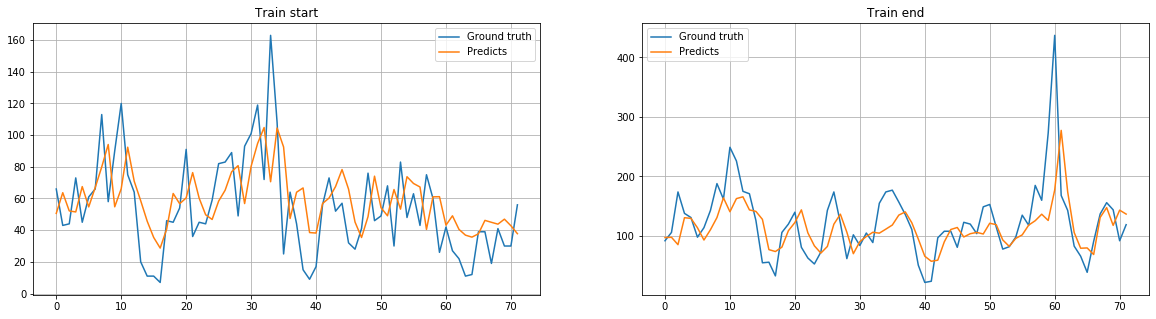

In [32]:
draw_plots(train_predicts)

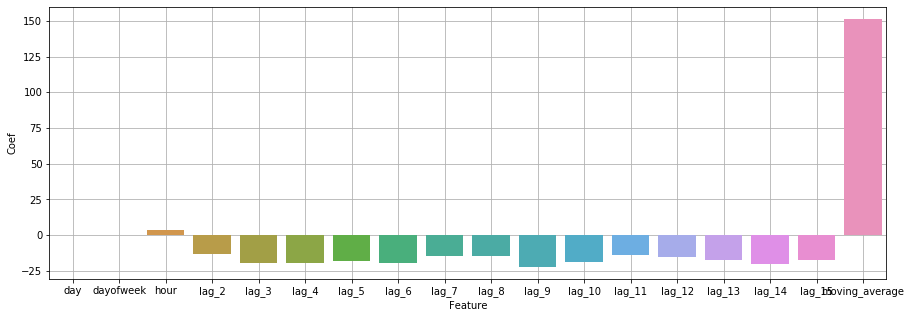

In [49]:
coef = pd.DataFrame(zip(linear_without_lag.coef_, new_X.columns))
plt.figure(figsize=(15, 5))
ax = sns.barplot(y=0, x=1, data=coef, zorder=3)
ax.grid(zorder=0)
ax.set_xlabel('Feature')
ax.set_ylabel('Coef')
plt.show()

Все логично, теперь на первое место вышла moving_averange.

## LGBMRegressor <a name='lgbmregressor'></a>

In [34]:
%%time
param = {
         'max_depth': np.arange(-1, 20, 2),
         'num_leaves': np.arange(22, 33, 2), 
         }
estimator = lgb.LGBMRegressor(n_estimators=1000,)
lgb_model = GridSearchCV(estimator, param, scoring=rmse_score, cv=3)
lgb_model.fit(X_train, y_train)

CPU times: user 38min 5s, sys: 25.9 s, total: 38min 31s
Wall time: 38min 55s


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=1000, n_jobs=-1,
                                     num_leaves=31, objective=None,
                                     random_state=None, reg_alpha=0.0,
                                     reg_lambda=0.0, silent=True, subsample=1.0,
                                     subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': array([-1,  1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                         'num_leaves': ar

In [46]:
lgb_model.best_score_, lgb_model.best_params_

(-25.09248373635627, {'max_depth': 15, 'num_leaves': 32})

In [35]:
train_predicts = lgb_model.predict(X_train)

rmse_history.loc['lgb_model', 'train'] = rmse(y_train, train_predicts)
print('training RMSE:', rmse_history.loc['lgb_model', 'train'])

training RMSE: 0.8916544185789419


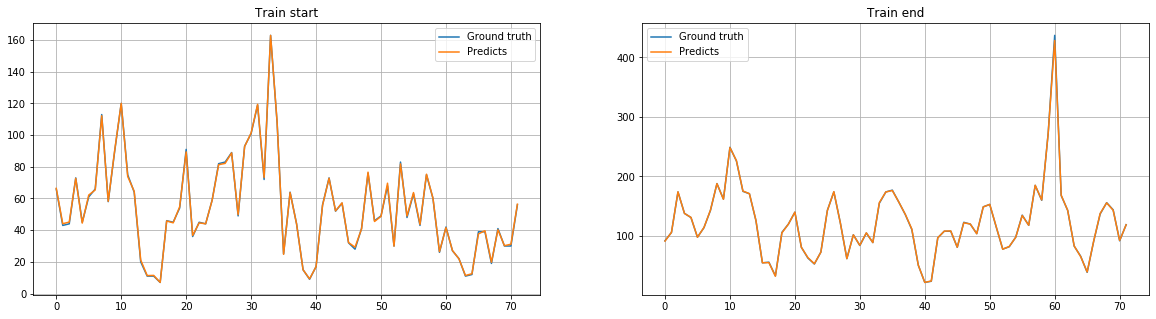

In [36]:
draw_plots(train_predicts)

Так тренировочные данные у нас выучили, но для ансамблей это не страшно

## RandomForestRegressor <a name='randomforestregressor'></a>

In [37]:
%%time
params = {'n_estimators': np.arange(10, 101, 10),
          'min_samples_split': np.arange(2, 11, 2),
          'min_samples_leaf': np.arange(1, 5)}
estimator_model = RandomForestRegressor(bootstrap=False, random_state=42)
forest_model = GridSearchCV(estimator_model, params, scoring=rmse_score, cv=2, n_jobs=-1)
forest_model.fit(X_train, y_train)

CPU times: user 11min 23s, sys: 364 ms, total: 11min 24s
Wall time: 11min 29s


GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=False, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'min_samples_leaf': array([1, 2, 3

In [47]:
forest_model.best_score_, forest_model.best_params_

(-33.219253438576786,
 {'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 10})

In [39]:
train_predicts = forest_model.predict(X_train)

rmse_history.loc['forest_model', 'train'] = rmse(y_train, train_predicts)
print('training RMSE:', rmse_history.loc['forest_model', 'train'])

training RMSE: 13.205356122279008


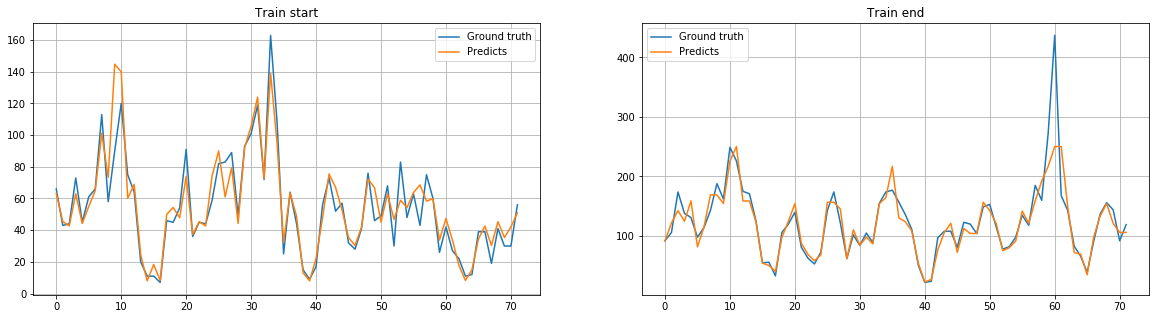

In [40]:
draw_plots(train_predicts)

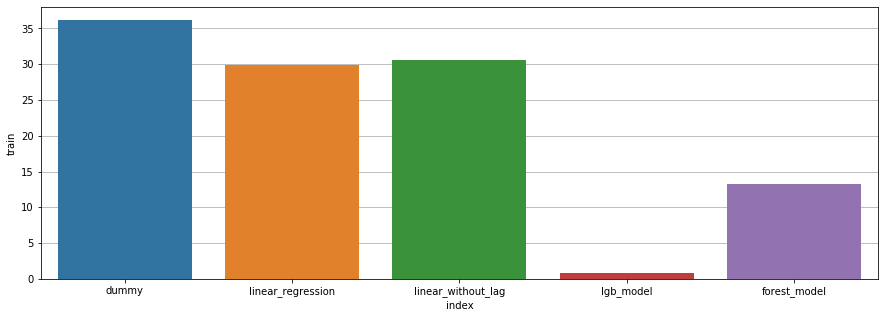

In [41]:
f, ax = plt.subplots(figsize=(15, 5));
sns.barplot(y='train', x='index', data=rmse_history.reset_index(), ax=ax, zorder=3);
ax.grid(axis='y', zorder=0)
f.show();

## Вывод: <a name='findings_3'></a>

Лушчей моделью оказалась LGBMRegressor со значениями RMSE: 
    * на тренировочных данных 0.89; 
    * на ваоидационных данных 25.1. 
    
На втором месте RandomForestRegressor со значениями RMSE: 
    * на тренировочных данных 13.2; 
    * на валидационных данных 33.21. 

По графикам видно, что LGBMRegressor полность выучил данные, а RandomForest только начал переобучаться, но все равно значение на RMSE не плохое

# 4. Тестирование <a name='testing_model'></a>

Проверить Dummy_model и lgb_model на тестовых данных

In [42]:
predicts = X_test['lag_1']
print('testing RMSE:', rmse(y_test, predicts))

testing RMSE: 58.856486242815066


In [44]:
predicts = lgb_model.predict(X_test)
print('testing RMSE:', rmse(y_test, predicts))

testing RMSE: 41.60660543818022


## Вывод: <a name='findings_3'></a>

LGBMRegressor Показал значения RMSE: 41.6. Хотя на кросс-валидации выдавал занчение 25.1. Это обусловлено тем, что тестовые данные отличаются от тренировочных тем, что на тестовых данных тренд растет быстрее.

# Выводы: <a name='findings'></a>
1. Данные преобразованы по часу и проверены на отсутствие пропусков и аномальных значений.
2. Проведен анализ данных. 
    * После разложения данных на тренды и сезонности выявлен нелинейный тренд вверх на протяжении всего временного отрезка. 
    * Так же обнаружена дневная сезонность с 6 утра до 12 вечера наблюдается рост заявок, после 12 идет на спад.
    * Анализ отстатков от разложения данных показал, что остатки распределены равномерно со средним равным 0 и стандартным отклонением равным 25.
3. Добалены признаки month, day, dayofweek, hour добавлены смещенные значения целевого признака от 1 до 15, добавлена скользящая средняя с периодом 15.
4. Данные поделены на тренировочную и тестовую выборки, признаки стандартизированы для линейной регрессии
5. Для экспериментов были выбраны следующие модели:
    * LinearRegression
    * LGBMRegressor
    * RandomForestRegressor
6. Лушчей моделью оказалась LGBMRegressor а на втором месте RandomForestRegressor:

|model name|Train RMSE|Valid RMSE|
|----------|:----------:|:----------:|
|FGBMRegressor|0.89|25.1|
|RandomForestRegressor|13.2|33.21|

7. Финальной моделью была выбрана LGBMRegressor, а для проверки на адекватность выбрана модель с запаздыванием
8. На тестовой выборке модель с запаздыванием показала RMSE 58.9, а RGBMRegressor показал значние 41.6
